<a href="https://colab.research.google.com/github/vlastimiltetour/content_based_recommender/blob/main/Content_Based_Recommendation_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#https://www.kaggle.com/code/shawamar/product-recommendation-system-for-e-commerce
!pip install requests lxml

In [6]:
import pandas
#%pip install pandas
# Library for text feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Library for finding nearest neighbors based on input data
from sklearn.neighbors import NearestNeighbors

# Library for performing K-means clustering
from sklearn.cluster import KMeans

# Library for evaluating the similarity between true and predicted clusters
from sklearn.metrics import adjusted_rand_score

import requests
import xml.etree.ElementTree as ET
from lxml import etree

import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from matplotlib import pyplot as plt

In [7]:
#get the product feed data

url = 'https://www.efirthebrand.cz/product_feed'  # Replace with your XML feed URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
  feed_data = response.content
else:
  print("Failed to retrieve XML data")
if feed_data:
  root = ET.fromstring(feed_data)

  data = []

  for item in root.findall('.//SHOPITEM'):
      item_id = item.find('ITEM_ID').text
      product_name = item.find('PRODUCTNAME').text
      product = item.find('PRODUCT').text
      category_text = item.find('CATEGORYTEXT').text
      description = item.find('DESCRIPTION').text
      img_url = item.find('IMGURL').text
      price_vat = item.find('PRICE_VAT').text


      data.append({
          "ID": item_id,
          "PRODUCTNAME": product_name,
          "PRODUCT": product,
          "CATEGORYTEXT": category_text,
          "DESCRIPTION": description,
          "IMGURL": img_url,
          "PRICE_VAT": price_vat
      })

  df = pd.DataFrame(data)

  print(df)

  df
  #dataframe characteristics





      ID    PRODUCTNAME        PRODUCT     CATEGORYTEXT  \
0    140       Afrodita       Afrodita       Podprsenky   
1    142       Afrodita       Afrodita  Podvazkové pasy   
2    141       Afrodita       Afrodita         Kalhotky   
3    194  Afrodita blue  Afrodita blue       Podprsenky   
4    193  Afrodita blue  Afrodita blue         Kalhotky   
..   ...            ...            ...              ...   
133   71           Wine           Wine         Kalhotky   
134   72           Wine           Wine         Kalhotky   
135   69           Wine           Wine       Podprsenky   
136   73           Wine           Wine  Podvazkové pasy   
137   70           Wine           Wine         Kalhotky   

                                           DESCRIPTION  \
0    Podprsenka je téměř celá krajková, s doplněním...   
1    Podvazkový pas je navržen tak, aby podtrhl a z...   
2    Kalhotky brazilky jsou nejenom nejpopulárnější...   
3    Podprsenka Afrodita Blue je mistrovským dílem ...   
4

Shape of ratings dataset is:  (130, 7) 

Max values in dataset are 
 960 

Min values in dataset are 
 1010 



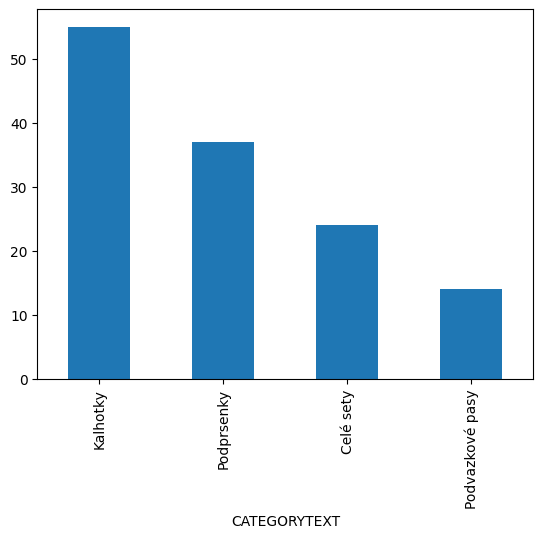

In [8]:
#remove darkove certifikaty form the df
df = df[df["CATEGORYTEXT"].str.contains("Dárkové certifikáty") == False]
print('Shape of ratings dataset is: ',df.shape, '\n')
print('Max values in dataset are \n',df['PRICE_VAT'].max(), '\n')
print('Min values in dataset are \n',df['PRICE_VAT'].min(), '\n')
df['CATEGORYTEXT'].value_counts().plot(kind='bar')

df["DESCRIPTION"].shape
df["DESCRIPTION"].head()

#fill emtpy
df.fillna({'DESCRIPTION':''}, inplace=True)


In [9]:
#add stop words
cz_stop_words = ["ačkoli", "ahoj", "ale", "anebo", "ano", "asi", "aspoň", "během", "bez", "beze",
             "blízko", "bohužel", "brzo", "bude", "budeme", "budeš", "budete", "budou", "budu",
             "byl", "byla", "byli", "bylo", "byly", "bys", "čau", "chce", "chceme", "chceš", "chcete",
             "chci", "chtějí", "chtít", "chut'", "chuti", "co", "čtrnáct", "čtyři", "dál", "dále", "daleko",
             "děkovat", "děkujeme", "děkuji", "den", "deset", "devatenáct", "devět", "do", "dobrý", "docela",
             "dva", "dvacet", "dvanáct", "dvě", "hodně", "já", "jak", "jde", "je", "jeden", "jedenáct", "jedna",
             "jedno", "jednou", "jedou", "jeho", "její", "jejich", "jemu", "jen", "jenom", "ještě", "jestli",
             "jestliže", "jí", "jich", "jím", "jimi", "jinak", "jsem", "jsi", "jsme", "jsou", "jste", "kam", "kde",
             "kdo", "kdy", "když", "ke", "kolik", "kromě", "která", "které", "kteří", "který", "kvůli", "má", "mají",
             "málo", "mám", "máme", "máš", "máte", "mé", "mě", "mezi", "mí", "mít", "mně", "mnou", "moc", "mohl",
             "mohou", "moje", "moji", "možná", "můj", "musí", "může", "my", "na", "nad", "nade", "nám", "námi",
             "naproti", "nás", "náš", "naše", "naši", "ne", "ně", "nebo", "nebyl", "nebyla", "nebyli", "nebyly",
             "něco", "nedělá", "nedělají", "nedělám", "neděláme", "neděláš", "neděláte", "nějak", "nejsi", "někde",
             "někdo", "nemají", "nemáme", "nemáte", "neměl", "němu", "není", "nestačí", "nevadí", "než", "nic", "nich",
             "ním", "nimi", "nula", "od", "ode", "on", "ona", "oni", "ono", "ony", "osm", "osmnáct", "pak", "patnáct",
             "pět", "po", "pořád", "potom", "pozdě", "před", "přes", "přese", "pro", "proč", "prosím", "prostě", "proti",
             "protože", "rovně", "se", "sedm", "sedmnáct", "šest", "šestnáct", "skoro", "smějí", "smí", "snad", "spolu",
             "sta", "sté", "sto", "ta", "tady", "tak", "takhle", "taky", "tam", "tamhle", "tamhleto", "tamto", "tě",
             "tebe", "tebou", "ted'", "tedy", "ten", "ti", "tisíc", "tisíce", "to", "tobě", "tohle", "toto", "třeba",
             "tři", "třináct", "trošku", "tvá", "tvé", "tvoje", "tvůj", "ty", "určitě", "už", "vám", "vámi", "vás",
             "váš", "vaše", "vaši", "ve", "večer", "vedle", "vlastně", "všechno", "všichni", "vůbec", "vy", "vždy", "za",
             "zač", "zatímco", "ze", "že", "aby", "aj", "ani", "az", "budem", "budes", "by", "byt", "ci", "clanek",
             "clanku", "clanky", "coz", "cz", "dalsi", "design", "dnes", "email", "ho", "jako", "jej", "jeji", "jeste",
             "ji", "jine", "jiz", "jses", "kdyz", "ktera", "ktere", "kteri", "kterou", "ktery", "ma", "mate", "mi", "mit",
             "muj", "muze", "nam", "napiste", "nas", "nasi", "nejsou", "neni", "nez", "nove", "novy", "pod", "podle",
             "pokud", "pouze", "prave", "pred", "pres", "pri", "proc", "proto", "protoze", "prvni", "pta", "re", "si",
             "strana", "sve", "svych", "svym", "svymi", "take", "takze", "tato", "tema", "tento", "teto", "tim", "timto",
             "tipy", "toho", "tohoto", "tom", "tomto", "tomuto", "tu", "tuto", "tyto", "uz", "vam", "vas", "vase", "vice",
             "vsak", "zda", "zde", "zpet", "zprávy"]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['chut', 'ted'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


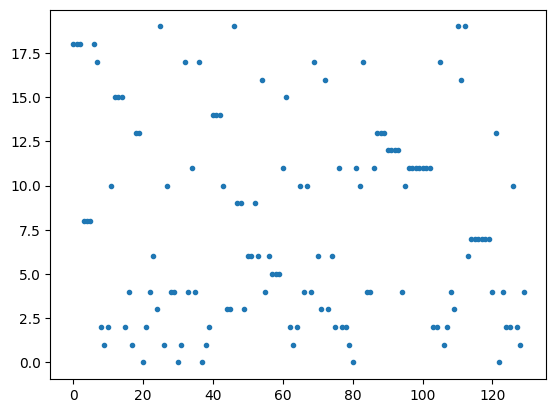

Top terms per cluster:
Product: Chantilly red
Recommendations:
      ID   PRODUCTNAME                                        DESCRIPTION
8     87        Andrea  Podprsenka s kosticemi v něžně růžové barvě sp...
10    88        Andrea  Podprsenka bez kostic v něžně růžové barvě s e...
15   101      Atlantis  Podprsenková skvost v zářivé královské modré b...
21    60         Bordo  Naše podprsenka v bohaté bordó elastické krajc...
39    97        Cherry  Podprsenka s kosticemi spojuje eleganci krajky...
70    84         Lilit  Vysoká tanga s exkluzivní krajkou v černém vzo...
72    91  Moulin Rouge  Podprsenka na kosticích v vášnivé červené barv...
83    47         Oceán  Podprsenka s kosticemi v zajímavé petrolejové ...
85    48     Oceán set  Podprsenka s kosticemi v zajímavé petrolejové ...
86     3      Orchidej  Podprsenka s kosticemi v černé krajkové elegan...
111   65           Sky  Brazilky v jemné světle modré krajce s elastic...
112   63           Sky  Podprsenka s kosticemi v 

In [10]:
#create a vectorizer matrix
vectorizer = TfidfVectorizer(stop_words=cz_stop_words)
#
matrix = vectorizer.fit_transform(df["DESCRIPTION"])
matrix
visualized_m=matrix
kmeans = KMeans(n_clusters = 20, init = 'k-means++')
y_kmeans = kmeans.fit_predict(visualized_m)
plt.plot(y_kmeans, ".")
plt.show()
true_k = 18

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(matrix)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()


df["cluster_labels"] = kmeans.labels_
df.sort_values(by="cluster_labels", ascending=True)
df["cluster_labels"].value_counts()
def show_recommendations(product_id):
    # Get the product description using the product ID
    product_name = df[df["ID"] == product_id]["PRODUCTNAME"].values[0]
    product_desc = df[df["ID"] == product_id]["DESCRIPTION"].values[0]

    # Transform the product description to a vector representation
    Y = vectorizer.transform([product_desc])

    # Predict the cluster for the product
    prediction = model.predict(Y)
    first_prediction = prediction[0]

    # Find products in the same cluster
    recommended_products_df = df[df['cluster_labels'] == first_prediction]

    # Optionally remove the input product from the recommendations, if it's in the list
    if product_id in recommended_products_df["ID"].values:
        recommended_products_df = recommended_products_df[recommended_products_df["ID"] != product_id]

    # Get the top 5 recommended products
    recommended_products = recommended_products_df[["ID", "PRODUCTNAME", "DESCRIPTION"]]

    return product_name, recommended_products

# Example usage:
product_name, recommendations = show_recommendations("50")
print(f"Product: {product_name}")
print("Recommendations:")
print(recommendations)

Text(value='', description='Insert Product ID:')

Output()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


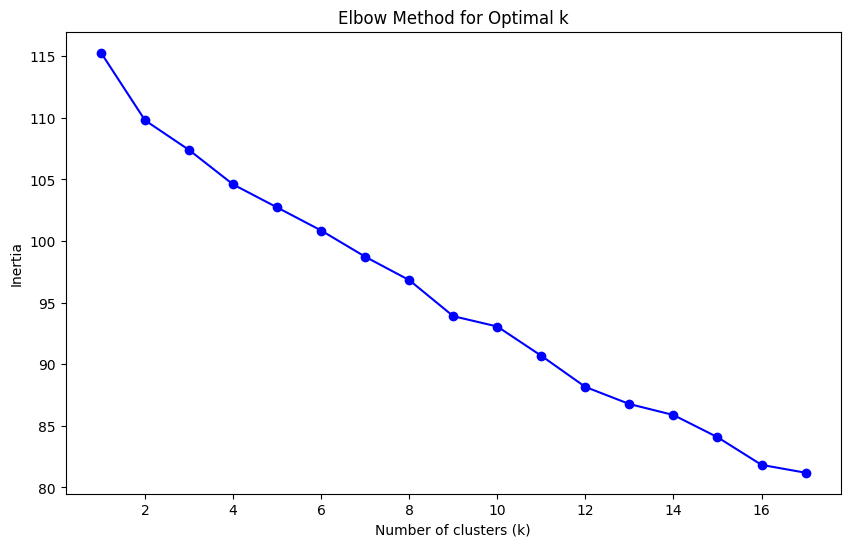

In [13]:
import ipywidgets as widgets
from IPython.display import display

product_id_input = widgets.Text(
    value='',
    description='Insert Product ID:',
    disabled=False
)

recommendation_list = widgets.Output()

def on_type(change):
    with recommendation_list:
        recommendation_list.clear_output()
        product_id = change['new']
        print(f"Product ID entered: {product_id}")
        try:
            recommendations = show_recommendations(str(product_id))
            if recommendations:
                display(recommendations)
            else:
                display("No recommendations available.")
        except Exception as e:
            display(f"Error: {e}")

product_id_input.observe(on_type, names='value')

display(product_id_input, recommendation_list)

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assuming 'df' is your DataFrame and 'vectorizer' is already defined and fitted.
# 'DESCRIPTION' column contains the text data to be vectorized.

# Step 1: Transform the descriptions to vector representations
X = vectorizer.transform(df['DESCRIPTION'])

# Step 2: Compute k-means for a range of k values
inertia = []
K = range(1, 18)  # You can adjust the range based on your dataset

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Step 3: Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [12]:
!pip freeze > requirements.txt